In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../..')

%matplotlib inline
sns.set()

In [2]:
from collections import namedtuple

Y = namedtuple('Y', ['mu', 'std', 'c_l', 'c_u'])
Keys = ['loss', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape']

In [3]:
import glob

In [4]:
dataset = 'btc_30m_close.csv'

In [5]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')

In [6]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')[0]
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')[0]
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')[0]
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')[0]
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')[0]

In [7]:
def get_ci(x, z=1.96):
    if x.ndim == 2:
        n = x.shape[1]
        mu = x.mean(axis=1)
        std = x.std(axis=1)
    else:
        n = x.shape[0]
        mu = x.mean()
        std = x.std()
        
    c_l, c_u = (mu - z * std/np.sqrt(n), mu + z * std/np.sqrt(n))
    return mu, std, c_l, c_u

In [8]:
def get_train_results(path, key='mae', z=1.96):
    return Y(*get_ci(pd.concat([pd.read_csv(x+'/train/results.csv')[key] for x in path], axis=1), z=z))

In [9]:
df_no_kaf = pd.read_csv(no_kaf + '/train/results.csv')
df_kaf_time = pd.read_csv(kaf_time + '/train/results.csv')
df_kaf_input = pd.read_csv(kaf_input + '/train/results.csv')
df_kaf_dual = pd.read_csv(kaf_dual + '/train/results.csv')
df_seq2seq = pd.read_csv(seq2seq + '/train/results.csv')

In [10]:
def smooth(x,w=0.5):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

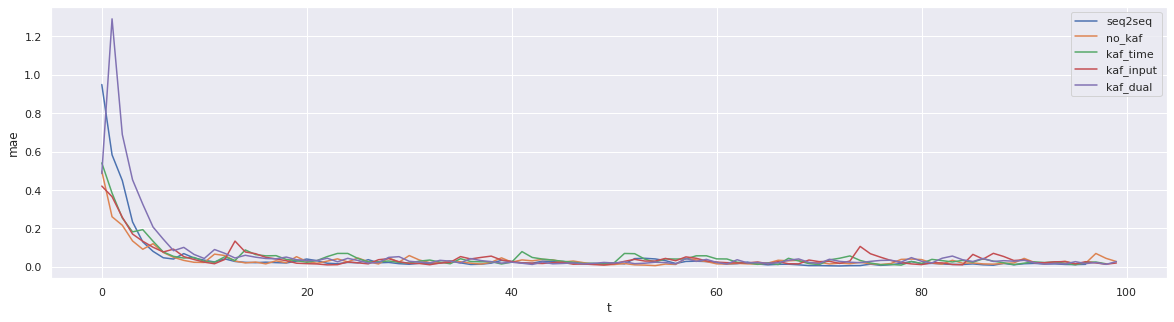

In [11]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

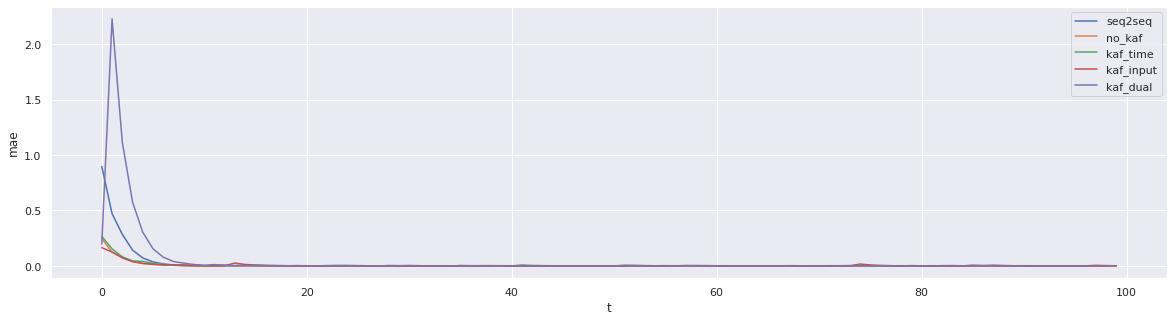

In [12]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.mse.values))
ax.plot(smooth(df_no_kaf.mse.values))
ax.plot(smooth(df_kaf_time.mse.values))
ax.plot(smooth(df_kaf_input.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [13]:
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))

In [14]:
np.sqrt(df_seq2seq.mean(axis=0).mse)

0.10652453706620911

In [15]:
# no reg
rows = ['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual']

table = pd.concat([df_seq2seq.mean(axis=0),
                   df_no_kaf.mean(axis=0), 
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.034756,0.001043,1.794067,0.011347,0.033713,0.073602,0.033713,7.296615
no_kaf,0.033396,0.000000,3.432417,0.004269,0.033396,0.073454,0.033396,8.559932
kaf_time,0.042968,0.001840,4.578833,0.005407,0.041128,0.093462,0.041128,14.624647
kaf_input,0.040120,0.002985,4.247921,0.004787,0.037135,0.072876,0.037135,8.567551
kaf_dual,0.060585,0.004906,4.415905,0.046569,0.055679,0.097257,0.055679,29.045809


In [16]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.010316,0.000104,0.073643,0.009291,0.010296,0.021577,0.010296,1.484008
no_kaf,0.005602,0.000000,0.081740,0.002498,0.005602,0.017003,0.005602,1.279025
kaf_time,0.006446,0.000447,0.201285,0.002732,0.006119,0.018047,0.006119,3.376016
kaf_input,0.005984,0.000238,0.148254,0.001936,0.005819,0.015128,0.005819,1.467940
kaf_dual,0.021352,0.000696,0.138813,0.042571,0.020935,0.022630,0.020935,13.288885


In [17]:
table.index

Index(['loss', 'reg', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape'], dtype='object')

In [18]:
header = table.index.tolist()

In [19]:
df_no_kaf = pd.read_csv(no_kaf + '/test/results.csv', header=None)
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))
df_no_kaf.columns = header

In [20]:
df_seq2seq = pd.read_csv(seq2seq+ '/test/results.csv', names=header)
df_kaf_time = pd.read_csv(kaf_time + '/test/results.csv', names=header)
df_kaf_input = pd.read_csv(kaf_input + '/test/results.csv', names=header)
df_kaf_dual = pd.read_csv(kaf_dual+ '/test/results.csv', names=header)

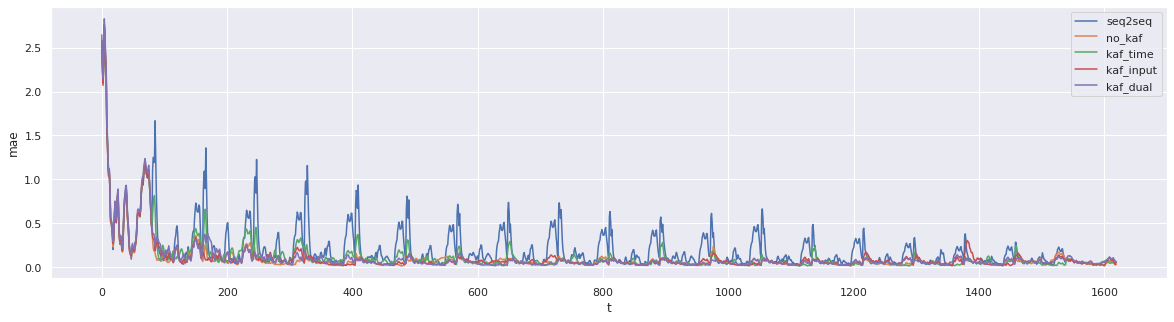

In [21]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [22]:
table = pd.concat([
                    df_seq2seq.mean(axis=0),
                    df_no_kaf.mean(axis=0), 
                    df_kaf_time.mean(axis=0), 
                    df_kaf_input.mean(axis=0), 
                    df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

In [23]:
# no reg
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.210255,0.001992,2.271243,0.138252,0.208264,0.286214,0.208263,58.894351
no_kaf,0.097053,0.000000,2.555777,0.057854,0.097053,0.157577,0.097053,30.223151
kaf_time,0.116462,0.002398,4.230521,0.064687,0.114065,0.179948,0.114065,40.014665
kaf_input,0.102819,0.003299,3.340538,0.057879,0.099519,0.157100,0.099519,28.696756
kaf_dual,0.104542,0.005797,3.504864,0.059750,0.098745,0.156002,0.098745,28.548244


In [24]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.007602,0.000046,0.032188,0.013737,0.007597,0.008670,0.007597,2.601201
no_kaf,0.005337,0.000000,0.042639,0.010979,0.005337,0.007883,0.005337,1.337301
kaf_time,0.005607,0.000143,0.075691,0.010950,0.005509,0.007812,0.005509,2.151066
kaf_input,0.005354,0.000076,0.060342,0.010988,0.005303,0.007724,0.005303,1.004810
kaf_dual,0.005584,0.000222,0.064197,0.011362,0.005428,0.007889,0.005428,1.052420


In [25]:
def last_path(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    idx = max(idxs)
    paths
    return base_path + '/report/' + ''.join([str(idx), '_', 'report.csv'])

In [26]:
df_no_kaf = pd.read_csv(last_path(no_kaf), index_col=0)
# df_dense = pd.read_csv(last_path(dense), index_col=0)
df_seq2seq = pd.read_csv(last_path(seq2seq), index_col=0)
df_kaf_time = pd.read_csv(last_path(kaf_time), index_col=0)
df_kaf_input = pd.read_csv(last_path(kaf_input), index_col=0)
df_kaf_dual = pd.read_csv(last_path(kaf_dual), index_col=0)

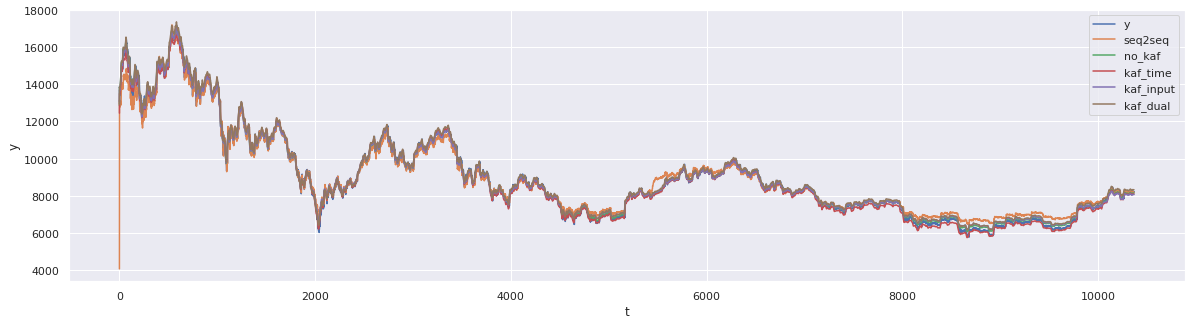

In [27]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df_no_kaf.y.values)
ax.plot(df_seq2seq.y_hat.values)
ax.plot(df_no_kaf.y_hat.values)
# ax.plot(df_dense.y_hat.values)
ax.plot(df_kaf_time.y_hat.values)
ax.plot(df_kaf_input.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y',
            'seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [28]:
from ntsa.utils.misc import regr_metrics

In [29]:
y = df_no_kaf.y.values
y_seq2seq = df_seq2seq.y_hat.values
y_no_kaf = df_no_kaf.y_hat.values
y_kaf_time = df_kaf_time.y_hat.values
y_kaf_input = df_kaf_input.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

In [30]:
metrics = [
list(regr_metrics(y, y_seq2seq).values()),
list(regr_metrics(y, y_no_kaf).values()),
list(regr_metrics(y, y_kaf_time).values()),
list(regr_metrics(y, y_kaf_input).values()),
list(regr_metrics(y, y_kaf_dual).values())
]

In [31]:
pd.DataFrame(np.array(metrics), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,95426.913961,212.065424,0.025739,0.011784,0.983061,2.544340
no_kaf,19071.949393,98.714428,0.011349,0.005496,0.996614,1.129204
time,24324.433580,123.432390,0.014219,0.006909,0.995682,1.431263
input,25650.350652,119.625596,0.014296,0.006657,0.995447,1.418155
dual,35334.025264,153.517826,0.017802,0.008498,0.993728,1.758827


In [32]:
import collections
def get_test_metrics(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    data  = {}
    for p,idx in zip(paths, idxs):
        data[idx] = pd.read_csv(p, index_col=0)
    data = collections.OrderedDict(sorted(data.items()))
    m = {}
    for k, v in data.items():
        m[k] = list(regr_metrics(v.y.values,v.y_hat.values).values())
    return np.array(list(m.values()))

In [33]:
table = [get_test_metrics(seq2seq).mean(axis=0),
get_test_metrics(no_kaf).mean(axis=0),
get_test_metrics(kaf_time).mean(axis=0),
get_test_metrics(kaf_input).mean(axis=0),
get_test_metrics(kaf_dual).mean(axis=0)]

pd.DataFrame(np.array(table), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,773649.469914,492.661914,0.056152,0.027419,0.862668,5.579717
no_kaf,323743.939566,229.585767,0.026025,0.012789,0.942531,2.617386
time,361982.995175,269.828279,0.029893,0.015054,0.935744,3.008247
input,323886.919472,235.420163,0.026480,0.013109,0.942506,2.662351
dual,334358.721262,233.587624,0.026228,0.013023,0.940647,2.645263


In [34]:
# std/n_checkpoints
table = [get_test_metrics(seq2seq).std(axis=0)/np.sqrt(20),
get_test_metrics(no_kaf).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_time).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_input).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_dual).std(axis=0)/np.sqrt(20)]

pd.DataFrame(np.array(table), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,279110.511043,79.189869,0.008437,0.004423,0.049546,0.877298
no_kaf,273659.017831,83.007630,0.008991,0.004632,0.048578,0.926931
time,265789.124547,82.003969,0.008937,0.004574,0.047181,0.919804
input,270275.301002,81.770671,0.008847,0.004566,0.047977,0.914419
dual,280914.907737,84.443108,0.009117,0.004714,0.049866,0.943233
